In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from lightgbm import LGBMRanker, LGBMRegressor
from multiprocessing import cpu_count

In [3]:
def reduce_mem_usage(df: pd.DataFrame,
                     verbose: bool = True) -> pd.DataFrame:
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == "int":
                if (c_min > np.iinfo(np.int8).min
                        and c_max < np.iinfo(np.int8).max):
                    df[col] = df[col].astype(np.int8)
                elif (c_min > np.iinfo(np.int16).min
                      and c_max < np.iinfo(np.int16).max):
                    df[col] = df[col].astype(np.int16)
                elif (c_min > np.iinfo(np.int32).min
                      and c_max < np.iinfo(np.int32).max):
                    df[col] = df[col].astype(np.int32)
                elif (c_min > np.iinfo(np.int64).min
                      and c_max < np.iinfo(np.int64).max):
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min
                      and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    reduction = (start_mem - end_mem) / start_mem

    msg = f"Mem. usage decreased to {end_mem:5.2f} MB" + \
        f" ({reduction * 100:.1f} % reduction)"
    if verbose:
        print(msg)

    return df

In [4]:
from scipy.stats import spearmanr


def custom_metric(t, y):
    from scipy.stats import spearmanr
    score = spearmanr(t, y, nan_policy="propagate")[0]
    return 'rho', score, True


In [5]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2, rank_col='Rank') -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """

    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df[rank_col].min() == 0
        assert df[rank_col].max() == len(df[rank_col]) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by=rank_col)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by=rank_col, ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf


In [6]:
def set_rank(df):
    """
    Args:
        df (pd.DataFrame): including predict column
    Returns:
        df (pd.DataFrame): df with Rank
    """
    # sort records to set Rank
    df = df.sort_values("predict", ascending=False)
    # set Rank starting from 0
    df.loc[:, "Rank"] = np.arange(len(df["predict"]))
    return df

In [6]:
train = pd.read_parquet('../Output/financials_train_agg_df.parquet')
val = pd.read_parquet('../Output/financials_val_agg_df.parquet')
df = pd.concat([train, val]).reset_index(drop=True)
rank_num = 100
df["qcut"] = pd.qcut(df['Target'], rank_num, duplicates='drop').cat.codes

In [167]:
# del unpivot_train

In [165]:
# [c for c in unpivot_train.columns]

['Date',
 'SecuritiesCode',
 'variable',
 'value',
 'Target_unpivot',
 'high_rank_unpivot',
 'RowId',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'AdjustmentFactor',
 'ExpectedDividend',
 'SupervisionFlag',
 'Target',
 'Section/Products',
 'NewMarketSegment',
 '33SectorCode',
 '17SectorCode',
 'NewIndexSeriesSizeCode',
 'Universe0',
 'weekday',
 'week',
 'month',
 'high_rank',
 'CumulativeAdjustmentFactor',
 'AdjustedOpen',
 'AdjustedHigh',
 'AdjustedLow',
 'AdjustedClose',
 'ror_1',
 'ror_2',
 'ror_3',
 'ror_4',
 'ror_5',
 'ror_6',
 'ror_7',
 'ror_8',
 'ror_9',
 'ror_10',
 'ror_20',
 'ror_40',
 'ror_60',
 'ror_100',
 'TradedAmount',
 'TradedAmount_1',
 'TradedAmount_5',
 'TradedAmount_10',
 'TradedAmount_20',
 'TradedAmount_40',
 'TradedAmount_60',
 'TradedAmount_100',
 'd_Amount',
 'PreviousClose',
 'range',
 'range_1',
 'range_5',
 'range_10',
 'range_20',
 'range_40',
 'range_60',
 'range_100',
 'd_atr',
 'gap_range',
 'gap_range_1',
 'gap_range_5',
 'gap_range_10',
 'gap_range

In [7]:
df['day'] = pd.to_datetime(df['Date']).dt.day

In [8]:
df.high_rank.min()

1

In [5]:
def rank_to_class(x):
    if x <= 100:
        return 0
    elif 100 < x <= 200:
        return 1
    elif 200 < x <= 300:
        return 2
    elif 300 < x <= 1700:
        return 3
    elif 1700 < x <= 1800:
        return 4
    elif 1800 < x:
        return 5

In [10]:
df['TargetClass'] = df['high_rank'].apply(rank_to_class)

In [11]:
df['TargetClass'].value_counts()

3    1922201
2     131830
1     128981
0     128665
4     100296
5      32558
Name: TargetClass, dtype: int64

In [12]:
df["Section/Products"] = df["Section/Products"].astype('category').cat.codes
df["NewMarketSegment"] = df["NewMarketSegment"].astype('category').cat.codes
df["33SectorCode"] = df["33SectorCode"].astype('category').cat.codes
df["17SectorCode"] = df["17SectorCode"].astype('category').cat.codes
df["NewIndexSeriesSizeCode"] = df["NewIndexSeriesSizeCode"].astype('category').cat.codes
df["week"] = df["week"].astype('category').cat.codes
df["TypeOfDocument"] = df["TypeOfDocument"].astype('category').cat.codes

In [13]:
df['ror_1_shift1'] = df.groupby('SecuritiesCode')['ror_1'].shift(1) * -1
df['ror_1_shift2'] = df.groupby('SecuritiesCode')['ror_1'].shift(2)
df['ror_1_shift3'] = df.groupby('SecuritiesCode')['ror_1'].shift(3) * -1
df['ror_1_shift4'] = df.groupby('SecuritiesCode')['ror_1'].shift(4)
df['ror_1_shift5'] = df.groupby('SecuritiesCode')['ror_1'].shift(5)
df['ror_1_shift6'] = df.groupby('SecuritiesCode')['ror_1'].shift(6) * -1
df['ror_1_shift7'] = df.groupby('SecuritiesCode')['ror_1'].shift(7) * -1
df['ror_1_shift8'] = df.groupby('SecuritiesCode')['ror_1'].shift(8)
df['ror_1_shift9'] = df.groupby('SecuritiesCode')['ror_1'].shift(9)

In [14]:
df['ror_5_shift1'] = df.groupby('SecuritiesCode')['ror_5'].shift(1)
df['ror_5_shift2'] = df.groupby('SecuritiesCode')['ror_5'].shift(2)
df['ror_5_shift3'] = df.groupby('SecuritiesCode')['ror_5'].shift(3)
df['ror_5_shift4'] = df.groupby('SecuritiesCode')['ror_5'].shift(4)
df['ror_5_shift5'] = df.groupby('SecuritiesCode')['ror_5'].shift(5)
df['ror_5_shift6'] = df.groupby('SecuritiesCode')['ror_5'].shift(6)
df['ror_5_shift7'] = df.groupby('SecuritiesCode')['ror_5'].shift(7)
df['ror_5_shift8'] = df.groupby('SecuritiesCode')['ror_5'].shift(8)
df['ror_5_shift9'] = df.groupby('SecuritiesCode')['ror_5'].shift(9)

In [15]:
df['ror_10_shift1'] = df.groupby('SecuritiesCode')['ror_10'].shift(1)
df['ror_10_shift2'] = df.groupby('SecuritiesCode')['ror_10'].shift(2)
df['ror_10_shift3'] = df.groupby('SecuritiesCode')['ror_10'].shift(3)
df['ror_10_shift4'] = df.groupby('SecuritiesCode')['ror_10'].shift(4)
df['ror_10_shift5'] = df.groupby('SecuritiesCode')['ror_10'].shift(5)
df['ror_10_shift6'] = df.groupby('SecuritiesCode')['ror_10'].shift(6)
df['ror_10_shift7'] = df.groupby('SecuritiesCode')['ror_10'].shift(7)
df['ror_10_shift8'] = df.groupby('SecuritiesCode')['ror_10'].shift(8)
df['ror_10_shift9'] = df.groupby('SecuritiesCode')['ror_10'].shift(9)

In [16]:
df['ror_20_shift1'] = df.groupby('SecuritiesCode')['ror_20'].shift(1)
df['ror_20_shift2'] = df.groupby('SecuritiesCode')['ror_20'].shift(2)
df['ror_20_shift3'] = df.groupby('SecuritiesCode')['ror_20'].shift(3)
df['ror_20_shift4'] = df.groupby('SecuritiesCode')['ror_20'].shift(4)
df['ror_20_shift5'] = df.groupby('SecuritiesCode')['ror_20'].shift(5)
df['ror_20_shift6'] = df.groupby('SecuritiesCode')['ror_20'].shift(6)
df['ror_20_shift7'] = df.groupby('SecuritiesCode')['ror_20'].shift(7)
df['ror_20_shift8'] = df.groupby('SecuritiesCode')['ror_20'].shift(8)
df['ror_20_shift9'] = df.groupby('SecuritiesCode')['ror_20'].shift(9)

In [17]:
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

time_config = {'val_split_date': '2021-11-01',
               'test_split_date': '2022-01-01'}

train = df[(df.Date < time_config['val_split_date'])]
val = df[(df.Date >= time_config['val_split_date']) & (df.Date < time_config['test_split_date'])]
test = df[(df.Date >= time_config['test_split_date'])]

In [18]:
print(train.shape)
print(val.shape)
print(test.shape)

(2286531, 298)
(84000, 298)
(74000, 298)


In [19]:
train_groups = train.groupby('Date')['SecuritiesCode'].nunique()
query_train = train_groups.values
query_val = [val.shape[0] / 2000] * 2000
query_test = [test.shape[0] / 2000] * 2000

In [20]:
not_use_cols = ["RowId", "Date", "Target", "high_rank", "low_rank", "qcut", "DateCode", "DisclosedDate", "DisclosedTime", "CurrentPeriodEndDate", "TypeOfCurrentPeriod", "CurrentFiscalYearStartDate", "CurrentFiscalYearEndDate"]
col_use = [c for c in df.columns if c not in not_use_cols]

In [21]:
col_use  = [
    'd_atr',
    'day_range_100', 'vola_5', 'vola_10', 'vola_20', 'vola_40', 'vola_60', 'vola_100',
    'ror_1_shift1', 'ror_1_shift2', 'ror_1_shift3', 'ror_1_shift4', 'ror_1_shift5',
    'ror_1_shift6', 'ror_1_shift7', 'ror_1_shift8', 'ror_1_shift9',
    'ror_5_shift1', 'ror_5_shift2', 'ror_5_shift3', 'ror_5_shift4', 'ror_5_shift5',
    'ror_5_shift6', 'ror_5_shift7', 'ror_5_shift8', 'ror_5_shift9',
    'ror_10_shift1', 'ror_10_shift2', 'ror_10_shift3', 'ror_10_shift4', 'ror_10_shift5',
    'ror_10_shift6', 'ror_10_shift7', 'ror_10_shift8', 'ror_10_shift9',
    'ror_20_shift1', 'ror_20_shift2', 'ror_20_shift3', 'ror_20_shift4', 'ror_20_shift5',
    'ror_20_shift6', 'ror_20_shift7', 'ror_20_shift8', 'ror_20_shift9',
]

In [22]:
col_use = [
    'Volume', '33SectorCode', '17SectorCode', 'Universe0', 'AdjustedOpen', 'AdjustedHigh', 'AdjustedLow', 'AdjustedClose',
    'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_vortex_ind_pos',
    'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff',
    'trend_ichimoku_conv', 'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg',
    'trend_cci', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
    'trend_psar_down', 'trend_psar_up_indicator', 'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k',
    'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_roc',
    'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal', 'momentum_pvo_hist', 'momentum_kama',
    'ror_1', 'ror_5', 'ror_10', 'ror_20', 'ror_40', 'ror_60', 'ror_100', 'TradedAmount_1', 'TradedAmount_5', 'TradedAmount_10',
    'TradedAmount_20', 'TradedAmount_40', 'TradedAmount_60', 'TradedAmount_100', 'd_Amount', 'PreviousClose', 'range_1', 'range_5',
    'range_10', 'range_20', 'range_40', 'range_60', 'range_100', 'd_atr', 'gap_range', 'gap_range_1', 'gap_range_5', 'gap_range_10', 'gap_range_20',
    'gap_range_40', 'gap_range_60', 'gap_range_100', 'day_range_1', 'day_range_5', 'day_range_10', 'day_range_20', 'day_range_40',
    'day_range_60', 'day_range_100', 'hig_range_1', 'hig_range_5', 'hig_range_10', 'hig_range_20', 'hig_range_40', 'hig_range_60',
    'hig_range_100', 'mi_1', 'mi_5', 'mi_10', 'mi_20', 'mi_40', 'mi_60', 'mi_100', 'vola_5', 'vola_10', 'vola_20', 'vola_40', 'vola_60',
    'vola_100', 'hl_5', 'hl_10', 'hl_20', 'hl_40', 'hl_60', 'hl_100', 'NetSales', 'OperatingProfit', 'OrdinaryProfit', 'Profit', 'EarningsPerShare',
    'TotalAssets', 'Equity', 'EquityToAssetRatio', 'BookValuePerShare', 'ResultDividendPerShare1stQuarter', 'ResultDividendPerShare2ndQuarter',
    'ResultDividendPerShare3rdQuarter', 'ResultDividendPerShareFiscalYearEnd', 'ResultDividendPerShareAnnual', 'NetSalesRatio', 'SecuritiesCode',
    'DisclosedDate_diff', 'MarketCapitalization', 'MarketCapitalization/NetSales'
]

In [70]:
col_use = [
    'day', 'weekday', 'week',
    'Volume',
    'd_Amount', 'd_atr',
    'gap_range_1', 'gap_range_5', 'gap_range_10',
    'vola_5', 'vola_10',
    'ror_1', 'ror_2', 'ror_3', 'ror_4', 'ror_5', 'ror_6',
    'ror_7', 'ror_8', 'ror_9', 'ror_10', 'ror_20',
    'ror_1_shift1', 'ror_1_shift2', 'ror_1_shift3', 'ror_1_shift4', 'ror_1_shift5',
    'ror_1_shift6', 'ror_1_shift7', 'ror_1_shift8', 'ror_1_shift9',
    'ror_1_mean_5',
    'ror_1_var_5',
]

In [71]:
col_use

['day',
 'weekday',
 'week',
 'Volume',
 'd_Amount',
 'd_atr',
 'gap_range_1',
 'gap_range_5',
 'gap_range_10',
 'vola_5',
 'vola_10',
 'ror_1',
 'ror_2',
 'ror_3',
 'ror_4',
 'ror_5',
 'ror_6',
 'ror_7',
 'ror_8',
 'ror_9',
 'ror_10',
 'ror_20',
 'ror_1_shift1',
 'ror_1_shift2',
 'ror_1_shift3',
 'ror_1_shift4',
 'ror_1_shift5',
 'ror_1_shift6',
 'ror_1_shift7',
 'ror_1_shift8',
 'ror_1_shift9',
 'ror_1_mean_5',
 'ror_1_var_5']

In [72]:
[c for c in train.columns]

['RowId',
 'Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'AdjustmentFactor',
 'ExpectedDividend',
 'SupervisionFlag',
 'Target',
 'Section/Products',
 'NewMarketSegment',
 '33SectorCode',
 '17SectorCode',
 'NewIndexSeriesSizeCode',
 'Universe0',
 'weekday',
 'week',
 'month',
 'high_rank',
 'CumulativeAdjustmentFactor',
 'AdjustedOpen',
 'AdjustedHigh',
 'AdjustedLow',
 'AdjustedClose',
 'ror_1',
 'ror_2',
 'ror_3',
 'ror_4',
 'ror_5',
 'ror_6',
 'ror_7',
 'ror_8',
 'ror_9',
 'ror_10',
 'ror_20',
 'ror_40',
 'ror_60',
 'ror_100',
 'TradedAmount',
 'TradedAmount_1',
 'TradedAmount_5',
 'TradedAmount_10',
 'TradedAmount_20',
 'TradedAmount_40',
 'TradedAmount_60',
 'TradedAmount_100',
 'd_Amount',
 'PreviousClose',
 'range',
 'range_1',
 'range_5',
 'range_10',
 'range_20',
 'range_40',
 'range_60',
 'range_100',
 'd_atr',
 'gap_range',
 'gap_range_1',
 'gap_range_5',
 'gap_range_10',
 'gap_range_20',
 'gap_range_40',
 'gap_range_60',
 'gap_range_100',
 'day_range',
 'day_range

In [ ]:
def custom_metric(t, y):
    from scipy.stats import spearmanr
    score = spearmanr(t, y, nan_policy="propagate")[0]
    return 'rho', score, False

In [104]:
model = LGBMRanker(
    metric="None",
    random_state=42,
    num_leaves=71,
    learning_rate=0.1,
    n_jobs=cpu_count(),
    label_gain=np.arange(rank_num),
    lambdarank_truncation_level=rank_num,
    # max_bin=127,
    # max_depth=10,
    # min_data_in_leaf=100,
    num_iterations=1000//2,
    )

In [107]:
model.fit(
    train[col_use], train['qcut'],
    group=train_groups,
    verbose=1,
    eval_set=[(val[col_use], val['qcut'])],
    eval_group=[query_val],
    eval_at=[1],  # Make evaluation for target=1 ranking, I choosed arbitrarily
    eval_metric=custom_metric,
    early_stopping_rounds=100,
)

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warni

ValueError: Series.dtypes must be int, float or bool

In [100]:
test['predict'] = model.predict(test[col_use])
test = test.reset_index(drop=True)
test = test.sort_values(["Date", "predict"], ascending=[True, False])
ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)

In [101]:
sharp_ratio, buf = calc_spread_return_sharpe(ranking, portfolio_size=200)

In [102]:
sharp_ratio

0.09527508679866091

In [103]:
buf

Date
2022-01-04    1.041674
2022-01-05   -0.334030
2022-01-06   -1.325774
2022-01-07   -1.407227
2022-01-11    2.523687
2022-01-12    1.672828
2022-01-13    0.437118
2022-01-14    2.150240
2022-01-17   -0.744015
2022-01-18   -1.569326
2022-01-19   -1.641990
2022-01-20    0.085848
2022-01-21    3.346900
2022-01-24   -0.120063
2022-01-25   -0.223484
2022-01-26   -1.911727
2022-01-27    0.196647
2022-01-28    2.584367
2022-01-31   -0.130032
2022-02-01    1.981056
2022-02-02   -1.230126
2022-02-03    2.045920
2022-02-04   -2.041683
2022-02-07   -2.623301
2022-02-08   -0.079199
2022-02-09    2.107519
2022-02-10    0.270110
2022-02-14   -2.111049
2022-02-15   -3.457062
2022-02-16    0.493773
2022-02-17    1.323994
2022-02-18    0.864866
2022-02-21   -0.191497
2022-02-22   -0.627804
2022-02-24   -0.178208
2022-02-25    2.420603
2022-02-28    2.316131
dtype: float64

In [7]:
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _BaseKFold

import lightgbm as lgb


In [8]:
# self defined GroupTimeSeriesSplit
class GroupTimeSeriesSplit(_BaseKFold):

    def __init__(self, n_splits=5, *, max_train_size=None):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        n_splits = self.n_splits
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_folds = n_splits + 1
        indices = np.arange(n_samples)
        group_counts = np.unique(groups, return_counts=True)[1]
        groups = np.split(indices, np.cumsum(group_counts)[:-1])
        n_groups = _num_samples(groups)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of groups: {1}.").format(n_folds, n_groups))
        test_size = (n_groups // n_folds)
        test_starts = range(test_size + n_groups % n_folds,
                            n_groups, test_size)
        for test_start in test_starts:
            if self.max_train_size:
                train_start = np.searchsorted(
                    np.cumsum(
                        group_counts[:test_start][::-1])[::-1] < self.max_train_size + 1, 
                        True)
                yield (np.concatenate(groups[train_start:test_start]),
                       np.concatenate(groups[test_start:test_start + test_size]))
            else:
                yield (np.concatenate(groups[:test_start]),
                       np.concatenate(groups[test_start:test_start + test_size]))

In [9]:
def lgbm_model(train_x, train_y, validation_x, valiastion_y,index):
    params = {
        # baseline parameters
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 7,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42,
        # "max_bin": 128,
        # "colsample_bytree": 0.9,
        # n_jobs=cpu_count(),
        # "reg_alpha": 0.2,
        # "reg_lambda": 0.2,
        
    }
    

    lg_train = lgb.Dataset(train_x, label=train_y)
    lg_validation = lgb.Dataset(validation_x, label=valiastion_y)
    evals_result_lgbm = {}
    
    model_lightgbm = lgb.train(params,lg_train, valid_sets=[lg_train, lg_validation], num_boost_round=2000 
                            , early_stopping_rounds = 200, evals_result=evals_result_lgbm, verbose_eval=100)
    
    # model_lightgbm.save_model(f'model_lightgbm_{index}.txt')
    # pre_test_lightgbm = model_lightgbm.predict(test_x, num_iteration=model_lightgbm.best_iteration)
    
    
    # return pre_test_lightgbm, model_lightgbm, evals_result_lgbm
    return  model_lightgbm, evals_result_lgbm

In [10]:
def lgbm_model_class(train_x, train_y, validation_x, valiastion_y,index):
    params = {
        # baseline parameters
        "objective" : "multiclass",
        # "metric" : "rmse",
        "num_leaves" : 7,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42,
        "num_class": 6,
        # "max_bin": 128,
        # "colsample_bytree": 0.9,
        # n_jobs=cpu_count(),
        # "reg_alpha": 0.2,
        # "reg_lambda": 0.2,
    }


    lg_train = lgb.Dataset(train_x, label=train_y)
    lg_validation = lgb.Dataset(validation_x, label=valiastion_y)
    evals_result_lgbm = {}
    
    model_lightgbm = lgb.train(params,lg_train, valid_sets=[lg_train, lg_validation], num_boost_round=2000 
                            , early_stopping_rounds = 200, evals_result=evals_result_lgbm, verbose_eval=100)
    
    # model_lightgbm.save_model(f'model_lightgbm_{index}.txt')
    # pre_test_lightgbm = model_lightgbm.predict(test_x, num_iteration=model_lightgbm.best_iteration)
    
    
    # return pre_test_lightgbm, model_lightgbm, evals_result_lgbm
    return  model_lightgbm, evals_result_lgbm

In [11]:
def custom_metric(t, y):
    from scipy.stats import spearmanr
    label = y.get_label()
    score = spearmanr(t, label, nan_policy="propagate")[0]
    return 'rho', score, True

In [ ]:
def lgbm_model_rank(train_x, train_y, validation_x, validation_y, query_train, query_validation):
    # params = {
    #     # baseline parameters
    #     "objective" : "lambdarank",
    #     # "objective" : "rank_xendcg",
    #     # "metric" : "None",
    #     "num_leaves" : 23,
    #     "learning_rate" : 0.01,
    #     # "bagging_fraction" : 0.6,
    #     # "feature_fraction" : 0.6,
    #     "bagging_seed" : 42,
    #     "verbosity" : -1,
    #     "seed": 42,
    #     # "num_class": 6,
    #     # "max_bin": 128,
    #     # "colsample_bytree": 0.9,
    #     # n_jobs=cpu_count(),
    #     # "reg_alpha": 0.2,
    #     # "reg_lambda": 0.2,
    #     "label_gain": np.arange(rank_num),
    #     "lambdarank_truncation_level": rank_num,
    #     # "ndcg_eval_at": np.concatenate([np.arange(200), np.arange(query_train.min()-200, query_train.min())]),
    #     "ndcg_eval_at": [1]
    # }
    params = {
        # baseline parameters
        "objective" : "lambdarank",
        # "objective" : "rank_xendcg",
        "metric" : "map",
        "num_leaves" : 23,
        "learning_rate" : 0.01,
        # "bagging_fraction" : 0.6,
        # "feature_fraction" : 0.6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42,
        # "num_class": 6,
        # "max_bin": 128,
        # "colsample_bytree": 0.9,
        # n_jobs=cpu_count(),
        # "reg_alpha": 0.2,
        # "reg_lambda": 0.2,
        "label_gain": np.arange(rank_num),
        "lambdarank_truncation_level": rank_num,
        # "ndcg_eval_at": np.concatenate([np.arange(200), np.arange(query_train.min()-200, query_train.min())]),
        # "ndcg_eval_at": [1]
    }


    lg_train = lgb.Dataset(train_x, label=train_y, group=query_train)
    lg_validation = lgb.Dataset(validation_x, label=validation_y, group=query_validation)
    evals_result_lgbm = {}
    
    model_lightgbm = lgb.train(params,lg_train, valid_sets=[lg_validation], num_boost_round=2000,
                               early_stopping_rounds=50, evals_result=evals_result_lgbm, verbose_eval=5,
                            #    eval_at=[1],  # Make evaluation for target=1 ranking, I choosed arbitrarily
                            #    feval=custom_metric,
                               )
    
    # model_lightgbm.save_model(f'model_lightgbm_{index}.txt')
    # pre_test_lightgbm = model_lightgbm.predict(test_x, num_iteration=model_lightgbm.best_iteration)
    
    
    # return pre_test_lightgbm, model_lightgbm, evals_result_lgbm
    return  model_lightgbm, evals_result_lgbm

In [508]:
not_use_cols = ["RowId", "Date", "Target", "TargetClass", "high_rank", "low_rank", "qcut", "DateCode", "DisclosedDate", "DisclosedTime", "CurrentPeriodEndDate", "TypeOfCurrentPeriod", "CurrentFiscalYearStartDate", "CurrentFiscalYearEndDate"]
col_use = [c for c in df.columns if c not in not_use_cols]

In [439]:
col_use = [
    'day', 'week', 'weekday', 'Volume', '33SectorCode', '17SectorCode', 'Universe0', 'AdjustedOpen', 'AdjustedHigh', 'AdjustedLow', 'AdjustedClose',
    'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_vortex_ind_pos',
    'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff',
    'trend_ichimoku_conv', 'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg',
    'trend_cci', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
    'trend_psar_down', 'trend_psar_up_indicator', 'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k',
    'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_roc',
    'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal', 'momentum_pvo_hist', 'momentum_kama',
    'ror_1', 'ror_5', 'ror_10', 'ror_20', 'ror_40', 'ror_60', 'ror_100', 'TradedAmount_1', 'TradedAmount_5', 'TradedAmount_10',
    'TradedAmount_20', 'TradedAmount_40', 'TradedAmount_60', 'TradedAmount_100', 'd_Amount', 'PreviousClose', 'range_1', 'range_5',
    'range_10', 'range_20', 'range_40', 'range_60', 'range_100', 'd_atr', 'gap_range', 'gap_range_1', 'gap_range_5', 'gap_range_10', 'gap_range_20',
    'gap_range_40', 'gap_range_60', 'gap_range_100', 'day_range_1', 'day_range_5', 'day_range_10', 'day_range_20', 'day_range_40',
    'day_range_60', 'day_range_100', 'hig_range_1', 'hig_range_5', 'hig_range_10', 'hig_range_20', 'hig_range_40', 'hig_range_60',
    'hig_range_100', 'mi_1', 'mi_5', 'mi_10', 'mi_20', 'mi_40', 'mi_60', 'mi_100', 'vola_5', 'vola_10', 'vola_20', 'vola_40', 'vola_60',
    'vola_100', 'hl_5', 'hl_10', 'hl_20', 'hl_40', 'hl_60', 'hl_100', 'NetSales', 'OperatingProfit', 'OrdinaryProfit', 'Profit', 'EarningsPerShare',
    'TotalAssets', 'Equity', 'EquityToAssetRatio', 'BookValuePerShare', 'ResultDividendPerShare1stQuarter', 'ResultDividendPerShare2ndQuarter',
    'ResultDividendPerShare3rdQuarter', 'ResultDividendPerShareFiscalYearEnd', 'ResultDividendPerShareAnnual', 'NetSalesRatio', 'SecuritiesCode',
    'DisclosedDate_diff', 'MarketCapitalization', 'MarketCapitalization/NetSales'
]

In [440]:
col_use  = [
    'day', 'week', 'weekday', 'Volume','AdjustedOpen', 'AdjustedHigh', 'AdjustedLow', 'AdjustedClose',
    'd_atr',
    'ror_1_shift1', 'ror_1_shift2', 'ror_1_shift3', 'ror_1_shift4', 'ror_1_shift5',
    'ror_1_shift6', 'ror_1_shift7', 'ror_1_shift8', 'ror_1_shift9',
    'ror_5_shift1', 'ror_5_shift2', 'ror_5_shift3', 'ror_5_shift4', 'ror_5_shift5',
    'ror_5_shift6', 'ror_5_shift7', 'ror_5_shift8', 'ror_5_shift9',
    'ror_10_shift1', 'ror_10_shift2', 'ror_10_shift3', 'ror_10_shift4', 'ror_10_shift5',
    'ror_10_shift6', 'ror_10_shift7', 'ror_10_shift8', 'ror_10_shift9',
    'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow',
    'momentum_rsi', 'momentum_stoch_rsi', 'momentum_wr', 'momentum_roc',
    'ror_1', 'ror_5', 'ror_10', 'ror_20', 'ror_40',
    'TradedAmount_1', 'TradedAmount_5', 'TradedAmount_10', 'TradedAmount_20', 'TradedAmount_40',
    'd_Amount','range_1', 'range_5', 'range_10', 'range_20', 'range_40',
    'gap_range_1', 'gap_range_5', 'gap_range_10', 'gap_range_20', 'gap_range_40',
    'day_range_1', 'day_range_5', 'day_range_10', 'day_range_20', 'day_range_40',
    'hig_range_1', 'hig_range_5', 'hig_range_10', 'hig_range_20', 'hig_range_40',
    'mi_1', 'mi_5', 'mi_10', 'mi_20', 'mi_40',
    'vola_5', 'vola_10', 'vola_20', 'vola_40',
    'hl_5', 'hl_10', 'hl_20', 'hl_40'
]

In [109]:
col_use  = [
    'day', 'week', 'weekday', 'Volume','AdjustedOpen', 'AdjustedHigh', 'AdjustedLow', 'AdjustedClose',
    'd_atr',
    'ror_1_shift1', 'ror_1_shift2', 'ror_1_shift3', 'ror_1_shift4', 'ror_1_shift5',
    'ror_1_shift6', 'ror_1_shift7', 'ror_1_shift8', 'ror_1_shift9',
    'TradedAmount_1', 'TradedAmount_5', 'TradedAmount_10', 'TradedAmount_20', 'TradedAmount_40',
    'd_Amount','range_1', 'range_5', 'range_10', 'range_20', 'range_40',
    'gap_range_1', 'gap_range_5', 'gap_range_10', 'gap_range_20', 'gap_range_40',
    'day_range_1', 'day_range_5', 'day_range_10', 'day_range_20', 'day_range_40',
    'vola_5', 'vola_10', 'vola_20', 'vola_40',
]

In [129]:
col_use

['day',
 'week',
 'weekday',
 'Volume',
 'AdjustedOpen',
 'AdjustedHigh',
 'AdjustedLow',
 'AdjustedClose',
 'd_atr',
 'ror_1_shift1',
 'ror_1_shift2',
 'ror_1_shift3',
 'ror_1_shift4',
 'ror_1_shift5',
 'ror_1_shift6',
 'ror_1_shift7',
 'ror_1_shift8',
 'ror_1_shift9',
 'TradedAmount_1',
 'TradedAmount_5',
 'TradedAmount_10',
 'TradedAmount_20',
 'TradedAmount_40',
 'd_Amount',
 'range_1',
 'range_5',
 'range_10',
 'range_20',
 'range_40',
 'gap_range_1',
 'gap_range_5',
 'gap_range_10',
 'gap_range_20',
 'gap_range_40',
 'day_range_1',
 'day_range_5',
 'day_range_10',
 'day_range_20',
 'day_range_40',
 'vola_5',
 'vola_10',
 'vola_20',
 'vola_40']

In [443]:
train_x = train[col_use]
train_y = train[['Target']]
groups = train[['Date']]

In [41]:
gtscv = GroupTimeSeriesSplit(n_splits=5, max_train_size=None)
for index, (train_id, val_id) in enumerate(gtscv.split(train_x, groups=groups)):
    model_lightgbm, evals_result_lgbm = lgbm_model(train_x.iloc[train_id], train_y.iloc[train_id], train_x.iloc[val_id], train_y.iloc[val_id], index)
    test['predict'] = model_lightgbm.predict(test[col_use])
    test = test.sort_values(["Date", "predict"], ascending=[True, False])
    ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)
    sharp_ratio, _ = calc_spread_return_sharpe(ranking, portfolio_size=200)
    print(sharp_ratio)
    ax = lgb.plot_metric(evals_result_lgbm, metric='rmse')
    plt.show()
    print('Output of LightGBM Model training..')

NameError: name 'train_x' is not defined

In [415]:
test['predict'] = model_lightgbm.predict(test[col_use])
test = test.reset_index(drop=True)
test = test.sort_values(["Date", "predict"], ascending=[True, False])
ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)

/var/folders/ym/2nhqmm5d6zn8mfrndqmv6l_40000gn/T/ipykernel_66691/1952439617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict'] = model_lightgbm.predict(test[col_use])


In [416]:
sharp_ratio, buf = calc_spread_return_sharpe(ranking, portfolio_size=200)

In [417]:
sharp_ratio

0.11173929107472132

In [ ]:
buf

In [509]:
col_use

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'AdjustmentFactor',
 'ExpectedDividend',
 'SupervisionFlag',
 'Section/Products',
 'NewMarketSegment',
 '33SectorCode',
 '17SectorCode',
 'NewIndexSeriesSizeCode',
 'Universe0',
 'weekday',
 'week',
 'month',
 'CumulativeAdjustmentFactor',
 'AdjustedOpen',
 'AdjustedHigh',
 'AdjustedLow',
 'AdjustedClose',
 'ror_1',
 'ror_5',
 'ror_10',
 'ror_20',
 'ror_40',
 'ror_60',
 'ror_100',
 'TradedAmount',
 'TradedAmount_1',
 'TradedAmount_5',
 'TradedAmount_10',
 'TradedAmount_20',
 'TradedAmount_40',
 'TradedAmount_60',
 'TradedAmount_100',
 'd_Amount',
 'PreviousClose',
 'range',
 'range_1',
 'range_5',
 'range_10',
 'range_20',
 'range_40',
 'range_60',
 'range_100',
 'd_atr',
 'gap_range',
 'gap_range_1',
 'gap_range_5',
 'gap_range_10',
 'gap_range_20',
 'gap_range_40',
 'gap_range_60',
 'gap_range_100',
 'day_range',
 'day_range_1',
 'day_range_5',
 'day_range_10',
 'day_range_20',
 'day_range_40',
 'day_range_60',
 'day_range_100',
 'hig_r

In [510]:
train_x = train[col_use]
train_y = train[['TargetClass']]
groups = train[['Date']]

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 0.640376	valid_1's multi_logloss: 0.790632
[200]	training's multi_logloss: 0.633156	valid_1's multi_logloss: 0.783323
[300]	training's multi_logloss: 0.629414	valid_1's multi_logloss: 0.781592
[400]	training's multi_logloss: 0.626891	valid_1's multi_logloss: 0.781511
[500]	training's multi_logloss: 0.624934	valid_1's multi_logloss: 0.781858
[600]	training's multi_logloss: 0.623347	valid_1's multi_logloss: 0.782932
Early stopping, best iteration is:
[412]	training's multi_logloss: 0.626625	valid_1's multi_logloss: 0.781416


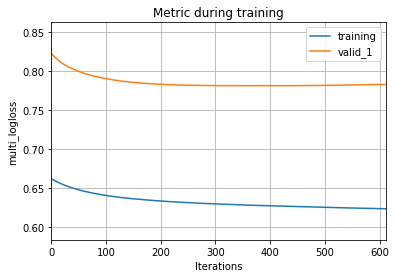

Output of LightGBM Model training..
Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 0.696932	valid_1's multi_logloss: 0.8159
[200]	training's multi_logloss: 0.687669	valid_1's multi_logloss: 0.806703
[300]	training's multi_logloss: 0.68308	valid_1's multi_logloss: 0.80257
[400]	training's multi_logloss: 0.68032	valid_1's multi_logloss: 0.800425
[500]	training's multi_logloss: 0.678338	valid_1's multi_logloss: 0.799334
[600]	training's multi_logloss: 0.676876	valid_1's multi_logloss: 0.798697
[700]	training's multi_logloss: 0.675757	valid_1's multi_logloss: 0.798238
[800]	training's multi_logloss: 0.674808	valid_1's multi_logloss: 0.798253
[900]	training's multi_logloss: 0.674017	valid_1's multi_logloss: 0.798268
Early stopping, best iteration is:
[741]	training's multi_logloss: 0.675352	valid_1's multi_logloss: 0.798223


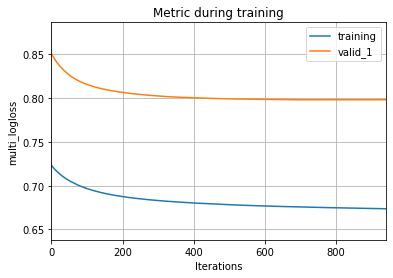

Output of LightGBM Model training..
Training until validation scores don't improve for 200 rounds


Error: Canceled future for execute_request message before replies were done

In [511]:
gtscv = GroupTimeSeriesSplit(n_splits=5, max_train_size=None)
for index, (train_id, val_id) in enumerate(gtscv.split(train_x, groups=groups)):
    model_lightgbm, evals_result_lgbm = lgbm_model_class(train_x.iloc[train_id], train_y.iloc[train_id], train_x.iloc[val_id], train_y.iloc[val_id], index)
    # test['predict'] = model_lightgbm.predict(test[col_use])
    # test = test.sort_values(["Date", "predict"], ascending=[True, False])
    # ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)
    # sharp_ratio, _ = calc_spread_return_sharpe(ranking, portfolio_size=200)
    # print(sharp_ratio)
    ax = lgb.plot_metric(evals_result_lgbm)
    plt.show()
    print('Output of LightGBM Model training..')

In [492]:
test['predict'] = np.argmax(model_lightgbm.predict(test[col_use].values), axis=1)

/var/folders/ym/2nhqmm5d6zn8mfrndqmv6l_40000gn/T/ipykernel_66691/913879300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict'] = np.argmax(model_lightgbm.predict(test[col_use].values), axis=1)


In [495]:
np.argmax(model_lightgbm.predict(test[col_use].values), axis=1)

array([3, 3, 3, ..., 3, 3, 3])

In [1]:
model_lightgbm.predict(test[col_use].values)

NameError: name 'model_lightgbm' is not defined

In [489]:
# np.argmax(result, axis=1)

(74000,)

In [120]:
# train_groups = train.groupby('Date')['SecuritiesCode'].nunique()
# query_train = train_groups.values
# query_val = [val.shape[0] / 2000] * 2000
# query_test = [test.shape[0] / 2000] * 2000

In [118]:
train_x = train[col_use]
train_y = train[['qcut']]
# train_y = train[['high_rank']]
groups = train[['Date']]

In [40]:
sharp_ratio_list = []

gtscv = GroupTimeSeriesSplit(n_splits=5, max_train_size=None)
for index, (train_id, val_id) in enumerate(gtscv.split(train_x, groups=groups)):
    train_groups = train.iloc[train_id].groupby('Date')['SecuritiesCode'].nunique()
    val_groups = train.iloc[val_id].groupby('Date')['SecuritiesCode'].nunique()

    model_lightgbm, evals_result_lgbm = lgbm_model_rank(train_x.iloc[train_id], train_y.iloc[train_id], train_x.iloc[val_id], train_y.iloc[val_id], train_groups, val_groups)
    test['predict'] = model_lightgbm.predict(test[col_use])
    test = test.sort_values(["Date", "predict"], ascending=[True, False])
    ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)
    sharp_ratio, _ = calc_spread_return_sharpe(ranking, portfolio_size=200)
    sharp_ratio_list.append(sharp_ratio)
    print(sharp_ratio)
    ax = lgb.plot_metric(evals_result_lgbm)
    plt.show()
    print('Output of LightGBM Model training..')

NameError: name 'train_x' is not defined

In [180]:
np.mean(sharp_ratio_list)

0.1613642761024165

In [179]:
sharp_ratio_list

[0.19183270372295388,
 0.18094221678508565,
 0.2654246149564939,
 0.08582567166418593,
 0.08279617338336322]

In [15]:
unpivot_train = pd.read_parquet('../Output/unpivot_train_df.parquet')
unpivot_val = pd.read_parquet('../Output/unpivot_val_df.parquet')

In [16]:
# unpivot_train = reduce_mem_usage(unpivot_train)
# unpivot_val = reduce_mem_usage(unpivot_val)

In [17]:
unpivot_df = pd.concat([unpivot_train, unpivot_val]).reset_index(drop=True)
rank_num = 100
unpivot_df["qcut"] = pd.qcut(unpivot_df['Target'], rank_num, duplicates='drop').cat.codes

Error: Canceled future for execute_request message before replies were done

In [ ]:
del unpivot_train, unpivot_val

In [ ]:
# unpivot_df['day'] = pd.to_datetime(unpivot_df['Date']).dt.day

In [ ]:
unpivot_df["Section/Products"] = unpivot_df["Section/Products"].astype('category').cat.codes
unpivot_df["NewMarketSegment"] = unpivot_df["NewMarketSegment"].astype('category').cat.codes
unpivot_df["33SectorCode"] = unpivot_df["33SectorCode"].astype('category').cat.codes
unpivot_df["17SectorCode"] = unpivot_df["17SectorCode"].astype('category').cat.codes
unpivot_df["NewIndexSeriesSizeCode"] = unpivot_df["NewIndexSeriesSizeCode"].astype('category').cat.codes
unpivot_df["week"] = unpivot_df["week"].astype('category').cat.codes
unpivot_df["TypeOfDocument"] = unpivot_df["TypeOfDocument"].astype('category').cat.codes
unpivot_df["variable"] = unpivot_df["variable"].astype('category').cat.codes

In [ ]:
unpivot_df.sort_values(["Date", "variable", "SecuritiesCode"], ascending=[True, True, True], inplace=True)

In [ ]:
# unpivot_train.sort_values(["Date", "variable", "SecuritiesCode"], ascending=[True, True, True], inplace=True)
# unpivot_val.sort_values(["Date", "variable", "SecuritiesCode"], ascending=[True, True, True], inplace=True)
# unpivot_test.sort_values(["Date", "variable", "SecuritiesCode"], ascending=[True, True, True], inplace=True)

In [ ]:
# unpivot_train["variable"] = unpivot_train["variable"].astype('category').cat.codes
# unpivot_val["variable"] = unpivot_val["variable"].astype('category').cat.codes
# unpivot_test["variable"] = unpivot_test["variable"].astype('category').cat.codes

In [ ]:
unpivot_df = unpivot_df.replace([np.inf, -np.inf], np.nan).fillna(0)

time_config = {'val_split_date': '2021-11-01',
               'test_split_date': '2022-01-01'}

unpivot_train = unpivot_df[(unpivot_df.Date < time_config['val_split_date'])]
unpivot_val = unpivot_df[(unpivot_df.Date >= time_config['val_split_date']) & (unpivot_df.Date < time_config['test_split_date'])]
unpivot_test = unpivot_df[(unpivot_df.Date >= time_config['test_split_date'])]

In [ ]:
del unpivot_df

In [ ]:
not_use_cols = [
    "RowId", "Date", "Target", "TargetClass", "high_rank", "low_rank", "qcut", "DateCode", "DisclosedDate", "DisclosedTime",
    "CurrentPeriodEndDate", "TypeOfCurrentPeriod", "CurrentFiscalYearStartDate", "CurrentFiscalYearEndDate",
    'Open', 'High', 'Low', 'Close','AdjustedOpen', 'AdjustedHigh', 'AdjustedLow', 'AdjustedClose', 'Target_unpivot'
]
col_use = [c for c in unpivot_train.columns if c not in not_use_cols]

In [ ]:
col_use = [
    'variable', 'value',
    # 'Volume', 'NewMarketSegment', '33SectorCode', '17SectorCode', 'NewIndexSeriesSizeCode', 'Universe0',
    'day', 'weekday', 'week', 'month',
    'ror_1', 'ror_2', 'ror_3', 'ror_4', 'ror_5', 'ror_6', 'ror_7', 'ror_8', 'ror_9', 'ror_10', 'ror_20',
    # 'TradedAmount_1', 'TradedAmount_5', 'TradedAmount_10', 'd_Amount',
    # 'range_1', 'range_5', 'range_10', 'range_20', 'd_atr',
    # 'gap_range_1', 'gap_range_5', 'gap_range_10', 'gap_range_20',
    # 'day_range_1', 'day_range_5', 'day_range_10', 'day_range_20',
    # 'hig_range_1', 'hig_range_5', 'hig_range_10', 'hig_range_20',
    # 'mi_1', 'mi_5', 'mi_10', 'mi_20',
    # 'vola_5', 'vola_10', 'vola_20', 'vola_40',
    # 'hl_5', 'hl_10', 'hl_20', 'hl_40',
    'ror_1_shift1', 'ror_1_shift2', 'ror_1_shift3', 'ror_1_shift4', 'ror_1_shift5',
    'ror_1_shift6', 'ror_1_shift7', 'ror_1_shift8', 'ror_1_shift9',
    'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
    'momentum_rsi', 'momentum_wr',
    # 'ror_1_AdjustedOpen_lag1_max',
    # 'ror_1_AdjustedOpen_lag1_min',
    # 'd_Amount_AdjustedClose_lag1_max',
    # 'd_Amount_AdjustedClose_lag1_min',
    # 'TradedAmount_1_AdjustedClose_lag1_max',
    # 'TradedAmount_1_AdjustedClose_lag1_min',
    # 'd_atr_Target_lag1_max',
    # 'd_atr_Target_lag1_min',
    # 'day_range_1_Target_lag1_max',
    # 'day_range_1_Target_lag1_min',
    # 'vola_5_high_rank_lag1_max',
    # 'vola_5_high_rank_lag1_min',
    # 'gap_range_1_high_rank_lag1_max',
    # 'gap_range_1_high_rank_lag1_min',
    # 'ror_1_mean_5', 'ror_1_var_5', 'ror_1_max_5', 'ror_1_min_5',
    # 'ror_1_skew_5', 'ror_1_kurt_5', 'ror_1_ewm_mean_5', 'ror_1_ewm_std_5',
    'TypeOfDocument',
    # 'NetSales', 'Profit', 'Equity',
    # 'NetSalesRatio',
    'DisclosedDate_diff',
    # 'MarketCapitalization'
]

In [ ]:
# col_use = [
#     'variable', 'value',
#     'Volume', 'NewMarketSegment', '33SectorCode', '17SectorCode', 'NewIndexSeriesSizeCode', 'Universe0',
#     'day', 'weekday', 'week', 'month',
#     'ror_1', 'ror_2', 'ror_3', 'ror_4', 'ror_5', 'ror_6', 'ror_7', 'ror_8', 'ror_9', 'ror_10', 'ror_20',
#     'TradedAmount_1', 'TradedAmount_5', 'TradedAmount_10', 'd_Amount',
#     'range_1', 'range_5', 'range_10', 'range_20', 'd_atr',
#     'gap_range_1', 'gap_range_5', 'gap_range_10', 'gap_range_20',
#     'day_range_1', 'day_range_5', 'day_range_10', 'day_range_20',
#     'hig_range_1', 'hig_range_5', 'hig_range_10', 'hig_range_20',
#     'mi_1', 'mi_5', 'mi_10', 'mi_20',
#     'vola_5', 'vola_10', 'vola_20', 'vola_40',
#     'hl_5', 'hl_10', 'hl_20', 'hl_40',
#     'ror_1_shift1', 'ror_1_shift2', 'ror_1_shift3', 'ror_1_shift4', 'ror_1_shift5',
#     'ror_1_shift6', 'ror_1_shift7', 'ror_1_shift8', 'ror_1_shift9',
#     'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
#     'momentum_rsi', 'momentum_wr',
#     'ror_1_AdjustedOpen_lag1_max',
#     'ror_1_AdjustedOpen_lag1_min',
#     'd_Amount_AdjustedClose_lag1_max',
#     'd_Amount_AdjustedClose_lag1_min',
#     'TradedAmount_1_AdjustedClose_lag1_max',
#     'TradedAmount_1_AdjustedClose_lag1_min',
#     'd_atr_Target_lag1_max',
#     'd_atr_Target_lag1_min',
#     'day_range_1_Target_lag1_max',
#     'day_range_1_Target_lag1_min',
#     'vola_5_high_rank_lag1_max',
#     'vola_5_high_rank_lag1_min',
#     'gap_range_1_high_rank_lag1_max',
#     'gap_range_1_high_rank_lag1_min',
#     'ror_1_mean_5', 'ror_1_var_5', 'ror_1_max_5', 'ror_1_min_5',
#     'ror_1_skew_5', 'ror_1_kurt_5', 'ror_1_ewm_mean_5', 'ror_1_ewm_std_5',
#     'TypeOfDocument',
#     'NetSales', 'Profit', 'Equity',
#     'NetSalesRatio',
#     'DisclosedDate_diff',
#     'MarketCapitalization'
# ]

In [ ]:
[c for c in col_use]

['SecuritiesCode',
 'variable',
 'value',
 'Volume',
 'AdjustmentFactor',
 'ExpectedDividend',
 'SupervisionFlag',
 'Section/Products',
 'NewMarketSegment',
 '33SectorCode',
 '17SectorCode',
 'NewIndexSeriesSizeCode',
 'Universe0',
 'day',
 'weekday',
 'week',
 'month',
 'CumulativeAdjustmentFactor',
 'ror_1',
 'ror_2',
 'ror_3',
 'ror_4',
 'ror_5',
 'ror_6',
 'ror_7',
 'ror_8',
 'ror_9',
 'ror_10',
 'ror_20',
 'ror_40',
 'ror_60',
 'ror_100',
 'TradedAmount',
 'TradedAmount_1',
 'TradedAmount_5',
 'TradedAmount_10',
 'TradedAmount_20',
 'TradedAmount_40',
 'TradedAmount_60',
 'TradedAmount_100',
 'd_Amount',
 'PreviousClose',
 'range',
 'range_1',
 'range_5',
 'range_10',
 'range_20',
 'range_40',
 'range_60',
 'range_100',
 'd_atr',
 'gap_range',
 'gap_range_1',
 'gap_range_5',
 'gap_range_10',
 'gap_range_20',
 'gap_range_40',
 'gap_range_60',
 'gap_range_100',
 'day_range',
 'day_range_1',
 'day_range_5',
 'day_range_10',
 'day_range_20',
 'day_range_40',
 'day_range_60',
 'day_ran

In [ ]:
unpivot_train_x = unpivot_train[col_use]
unpivot_train_y = unpivot_train[['qcut']]
# train_y = train[['high_rank']]
unpivot_groups = unpivot_train[['Date']]

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 50 rounds
[5]	valid_0's ndcg@1: 0.507785
[10]	valid_0's ndcg@1: 0.508311
[15]	valid_0's ndcg@1: 0.532716
[20]	valid_0's ndcg@1: 0.527772
[25]	valid_0's ndcg@1: 0.542973
[30]	valid_0's ndcg@1: 0.539449
[35]	valid_0's ndcg@1: 0.533505
[40]	valid_0's ndcg@1: 0.531664
[45]	valid_0's ndcg@1: 0.531086
[50]	valid_0's ndcg@1: 0.526089
[55]	valid_0's ndcg@1: 0.521302
[60]	valid_0's ndcg@1: 0.519198
[65]	valid_0's ndcg@1: 0.513518
[70]	valid_0's ndcg@1: 0.53077
[75]	valid_0's ndcg@1: 0.518567
Early stopping, best iteration is:
[27]	valid_0's ndcg@1: 0.549495
0.14230464245201924


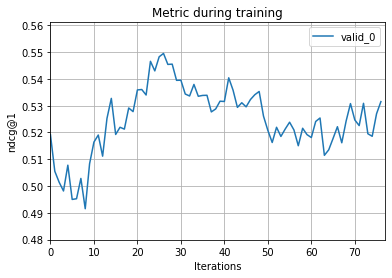

Output of LightGBM Model training..


/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 50 rounds
[5]	valid_0's ndcg@1: 0.488271
[10]	valid_0's ndcg@1: 0.477751
[15]	valid_0's ndcg@1: 0.506943
[20]	valid_0's ndcg@1: 0.517515
[25]	valid_0's ndcg@1: 0.51478
[30]	valid_0's ndcg@1: 0.50689
[35]	valid_0's ndcg@1: 0.519724
[40]	valid_0's ndcg@1: 0.510257
[45]	valid_0's ndcg@1: 0.509836
[50]	valid_0's ndcg@1: 0.514096
[55]	valid_0's ndcg@1: 0.498317
[60]	valid_0's ndcg@1: 0.49979
[65]	valid_0's ndcg@1: 0.500421
[70]	valid_0's ndcg@1: 0.481249
[75]	valid_0's ndcg@1: 0.478829
[80]	valid_0's ndcg@1: 0.485194
[85]	valid_0's ndcg@1: 0.478277
Early stopping, best iteration is:
[35]	valid_0's ndcg@1: 0.519724
0.19159925062795458


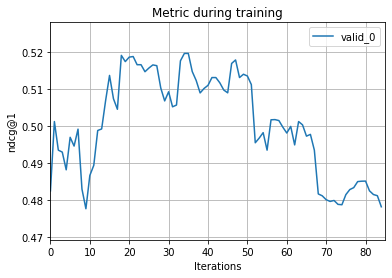

Output of LightGBM Model training..


/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 50 rounds
[5]	valid_0's ndcg@1: 0.517743
[10]	valid_0's ndcg@1: 0.496598
[15]	valid_0's ndcg@1: 0.487712
[20]	valid_0's ndcg@1: 0.498442
[25]	valid_0's ndcg@1: 0.485977
[30]	valid_0's ndcg@1: 0.491762
[35]	valid_0's ndcg@1: 0.4947
[40]	valid_0's ndcg@1: 0.489966
[45]	valid_0's ndcg@1: 0.494279
[50]	valid_0's ndcg@1: 0.509323
[55]	valid_0's ndcg@1: 0.50685
Early stopping, best iteration is:
[5]	valid_0's ndcg@1: 0.517743
0.15292078458041583


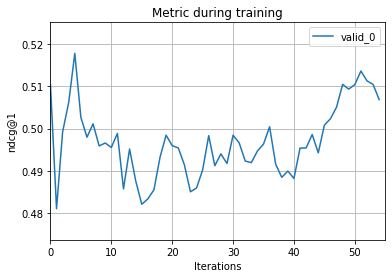

Output of LightGBM Model training..


/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Error: Canceled future for execute_request message before replies were done

In [ ]:
sharp_ratio_list = []

gtscv = GroupTimeSeriesSplit(n_splits=3, max_train_size=None)
for index, (train_id, val_id) in enumerate(gtscv.split(unpivot_train_x, groups=unpivot_groups)):
    train_groups = unpivot_train.iloc[train_id].groupby(['Date', 'variable'])['SecuritiesCode'].nunique()
    val_groups = unpivot_train.iloc[val_id].groupby(['Date', 'variable'])['SecuritiesCode'].nunique()

    model_lightgbm, evals_result_lgbm = lgbm_model_rank(unpivot_train_x.iloc[train_id], unpivot_train_y.iloc[train_id], unpivot_train_x.iloc[val_id], unpivot_train_y.iloc[val_id], train_groups, val_groups)
    unpivot_test['predict'] = model_lightgbm.predict(unpivot_test[col_use])
    unpivot_test = unpivot_test.sort_values(["Date", "predict"], ascending=[True, False])
    ranking = unpivot_test.groupby("Date").apply(set_rank).reset_index(drop=True)
    sharp_ratio, _ = calc_spread_return_sharpe(ranking, portfolio_size=200)
    sharp_ratio_list.append(sharp_ratio)
    print(sharp_ratio)
    ax = lgb.plot_metric(evals_result_lgbm)
    plt.show()
    print('Output of LightGBM Model training..')